In [1]:
import os
os.chdir('..')

In [50]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import policies
import pandas as pd

In [3]:
# RESULTS_DIR = "../results/movielens_evaluation_v8"

In [4]:
# p = Path(RESULTS_DIR)

In [5]:
# pickle_paths = p.glob("./*.pickle")

In [9]:
pickle_paths = [
    "results/debug/results_movielens_config_14_t_100000_n_1_d_120.pickle",
    "results/debug/results_movielens_config_16_t_100000_n_1_d_120.pickle",
#     "../results/results_movielens_config_14_t_100000_n_5_d_120.pickle"
]

In [35]:
reward_dict = {}
ndcg_dict = {}
time_dict = {}
policies = {}
for i, p in enumerate(pickle_paths):
    with open(p, "rb") as f:
        d = pickle.load(f)
    stats_dict = d[0][0]
    one_rew_dict = d[1]
    one_ndcg_dict = d[2]
    one_policy_dict = d[-1]
    for key in one_rew_dict:
        rew_list = one_rew_dict[key]
        ndcg_list = one_ndcg_dict[key]
        
        mean_rew = np.mean(np.stack(rew_list), axis=0)
        mean_ndcg = np.mean(np.stack(ndcg_list), axis=0)
        if i == 0:
            desc = 'after 1k'
        else:
            desc = 'after 4k'
        key_new = key + f' {desc}'
        policies[key_new] = one_policy_dict[key]
        reward_dict[key_new] = mean_rew
        ndcg_dict[key_new] = mean_ndcg
#         assert key == stats_dict[0]
        time_dict[key_new] = stats_dict[1]['Time mean']

In [36]:
reward_dict

{'DeepFM after 1k': array([[0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        ...,
        [2.0307e+04],
        [2.0308e+04],
        [2.0309e+04]]),
 'DeepFM after 4k': array([[    0.],
        [    0.],
        [    0.],
        ...,
        [20360.],
        [20361.],
        [20362.]])}

In [37]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

# Plot the results

In [38]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    plt.savefig(f'movielens_results_ndcg', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

In [39]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
        else:
            to_plot = rewards
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    
    plot_name = 'ctr' if plot_type == "CTR" else 'reward'
    plt.savefig(f'movielens_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

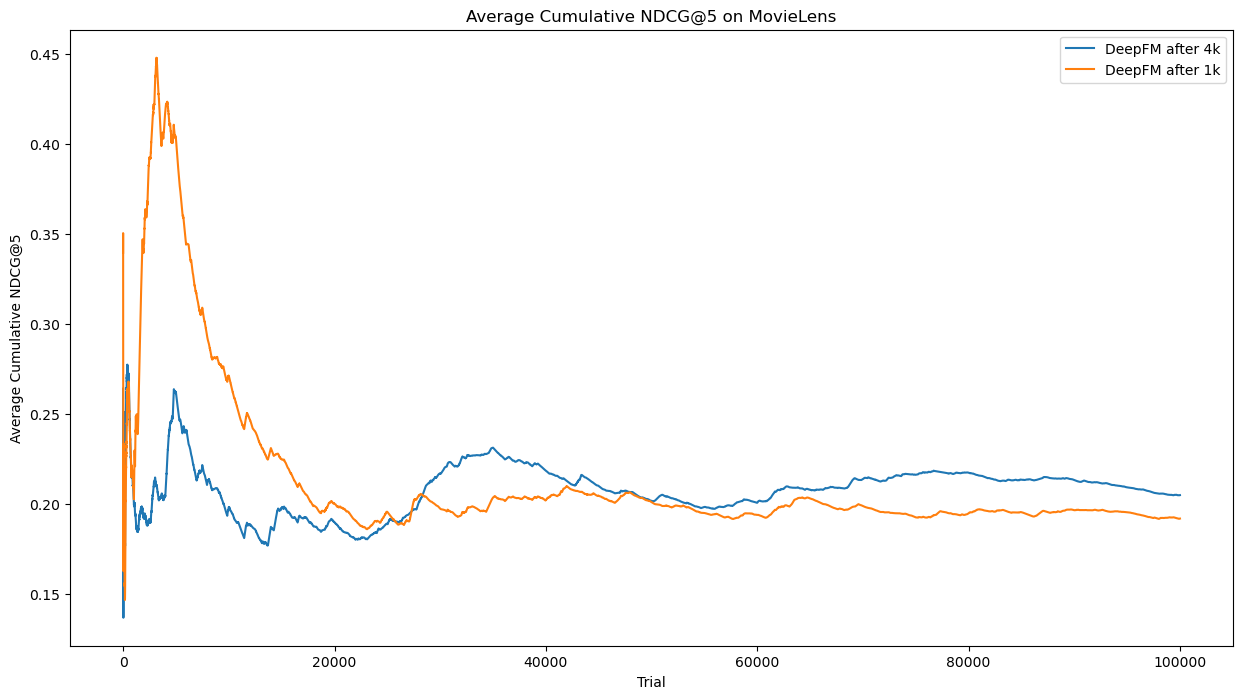

In [40]:
plot_ndcg(ndcg_dict)

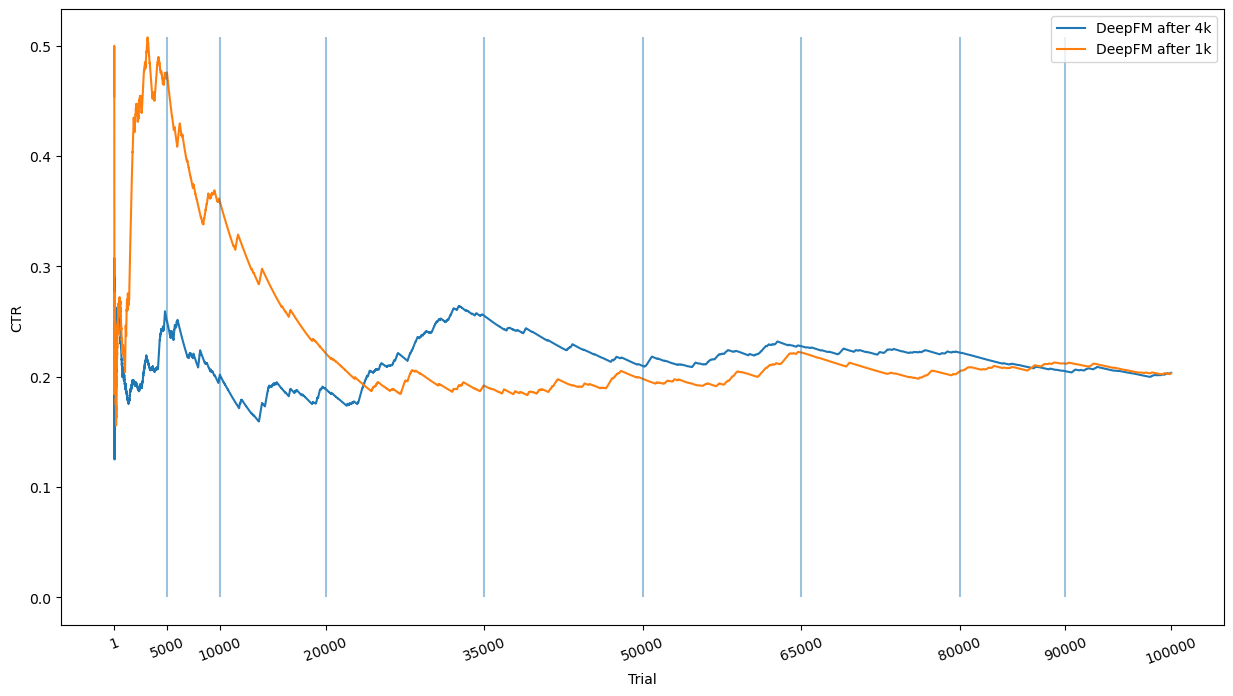

In [41]:
plot_ctrs_or_rewards(reward_dict, "CTR", CHANGE_POINTS);

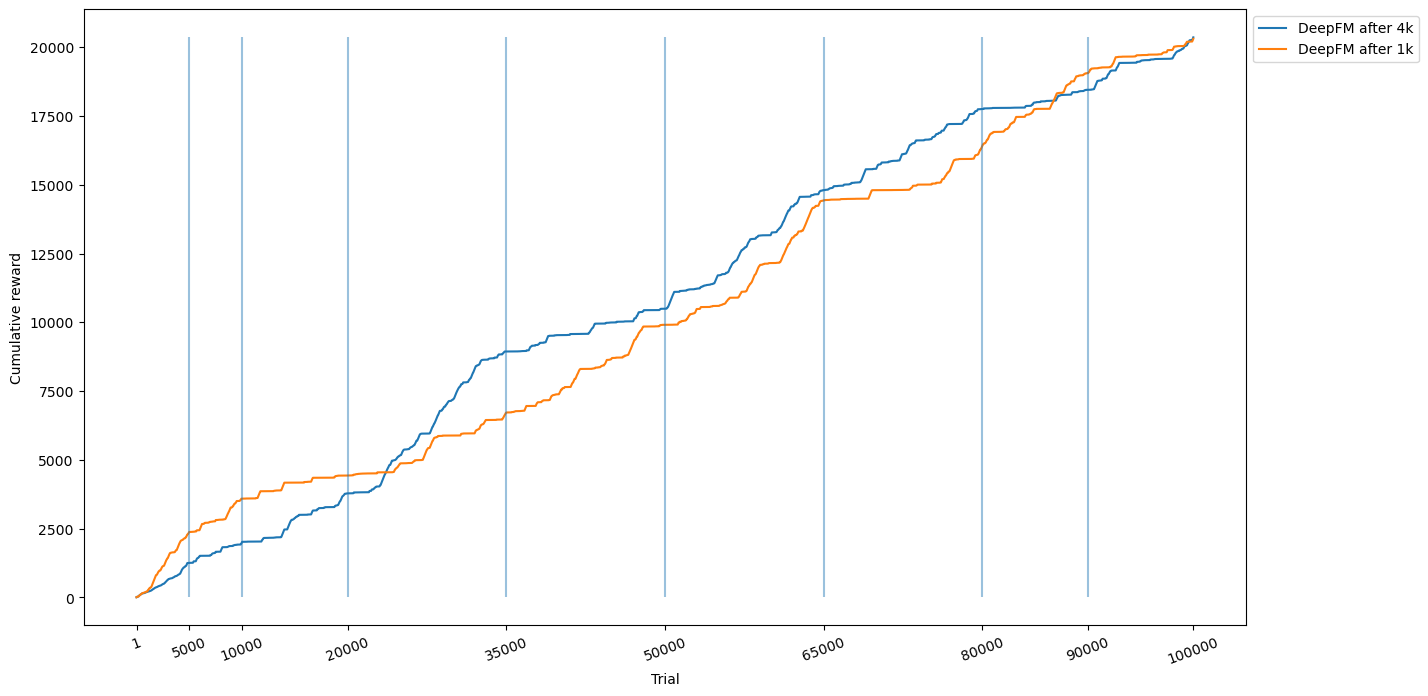

In [42]:
plot_ctrs_or_rewards(reward_dict, "Cumulative reward", CHANGE_POINTS);

# Create the tables

In [45]:
deepfm1 = policies['DeepFM after 1k']
deepfm4 = policies['DeepFM after 4k']

In [52]:
pd.DataFrame(deepfm1.estimated_rewards)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.658603,0.343121,0.474481,0.049181,0.446108,0.480535,0.176179,0.683157,0.748608,0.544485,...,0.106760,0.006585,0.399157,0.483115,0.253817,0.347589,0.216558,0.263293,0.014620,0.925132
1,0.012209,0.216216,0.144989,0.398203,0.622742,0.721932,0.374445,0.594599,0.589367,0.811953,...,0.730303,0.803743,0.754464,0.126213,0.912611,0.218341,0.815821,0.582076,0.379945,0.881388
2,0.374918,0.449812,0.243110,0.921433,0.146419,0.447525,0.057469,0.504245,0.928627,0.698002,...,0.734316,0.013803,0.064389,0.252339,0.312667,0.495521,0.276603,0.160605,0.905012,0.720179
3,0.836861,0.485677,0.046563,0.188009,0.097193,0.536663,0.277867,0.214334,0.165654,0.249682,...,0.060453,0.273717,0.098899,0.882728,0.555163,0.435388,0.756346,0.179783,0.176276,0.415393
4,0.313312,0.125092,0.025064,0.196886,0.893024,0.342209,0.208254,0.041280,0.599483,0.976512,...,0.750707,0.874381,0.641489,0.433262,0.832762,0.330510,0.858277,0.237587,0.963284,0.928836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.006334,0.622971,0.065647,0.001150,0.728167,0.063736,0.164579,0.074461,0.121064,0.127423,...,0.001402,0.003702,0.395555,0.010038,0.260685,0.070471,0.159660,0.024305,0.081414,0.482042
99996,0.006334,0.622971,0.065647,0.001150,0.728167,0.063736,0.164579,0.074461,0.121064,0.127423,...,0.001402,0.003702,0.395555,0.010038,0.260685,0.070471,0.159660,0.024305,0.081414,0.482042
99997,0.006334,0.622971,0.065647,0.001150,0.728167,0.063736,0.164579,0.074461,0.121064,0.127423,...,0.001402,0.003702,0.395555,0.010038,0.260685,0.070471,0.159660,0.024305,0.081414,0.482042
99998,0.006334,0.622971,0.065647,0.001150,0.728167,0.063736,0.164579,0.074461,0.121064,0.127423,...,0.001402,0.003702,0.395555,0.010038,0.260685,0.070471,0.159660,0.024305,0.081414,0.482042


In [62]:
act1 = deepfm1.chosen_actions.argmax(axis=1)

In [91]:
list(enumerate(act1))[45500:]

[(45500, 425),
 (45501, 425),
 (45502, 425),
 (45503, 425),
 (45504, 425),
 (45505, 425),
 (45506, 425),
 (45507, 425),
 (45508, 425),
 (45509, 425),
 (45510, 425),
 (45511, 425),
 (45512, 425),
 (45513, 425),
 (45514, 425),
 (45515, 425),
 (45516, 425),
 (45517, 425),
 (45518, 425),
 (45519, 425),
 (45520, 425),
 (45521, 425),
 (45522, 425),
 (45523, 425),
 (45524, 425),
 (45525, 425),
 (45526, 425),
 (45527, 425),
 (45528, 425),
 (45529, 425),
 (45530, 425),
 (45531, 425),
 (45532, 425),
 (45533, 425),
 (45534, 425),
 (45535, 425),
 (45536, 425),
 (45537, 425),
 (45538, 425),
 (45539, 425),
 (45540, 425),
 (45541, 425),
 (45542, 425),
 (45543, 425),
 (45544, 425),
 (45545, 425),
 (45546, 425),
 (45547, 425),
 (45548, 425),
 (45549, 425),
 (45550, 425),
 (45551, 425),
 (45552, 425),
 (45553, 425),
 (45554, 425),
 (45555, 425),
 (45556, 425),
 (45557, 425),
 (45558, 425),
 (45559, 425),
 (45560, 425),
 (45561, 425),
 (45562, 425),
 (45563, 425),
 (45564, 425),
 (45565, 425),
 (45566, 4

In [77]:
act2 = deepfm4.chosen_actions.argmax(axis=1)

In [80]:
list(enumerate(act2))[3500:]

[(3500, 231),
 (3501, 624),
 (3502, 98),
 (3503, 348),
 (3504, 40),
 (3505, 701),
 (3506, 450),
 (3507, 593),
 (3508, 247),
 (3509, 166),
 (3510, 299),
 (3511, 474),
 (3512, 278),
 (3513, 543),
 (3514, 249),
 (3515, 306),
 (3516, 884),
 (3517, 415),
 (3518, 933),
 (3519, 649),
 (3520, 914),
 (3521, 498),
 (3522, 611),
 (3523, 359),
 (3524, 180),
 (3525, 304),
 (3526, 949),
 (3527, 498),
 (3528, 609),
 (3529, 934),
 (3530, 705),
 (3531, 585),
 (3532, 929),
 (3533, 222),
 (3534, 407),
 (3535, 277),
 (3536, 72),
 (3537, 364),
 (3538, 832),
 (3539, 792),
 (3540, 700),
 (3541, 871),
 (3542, 332),
 (3543, 63),
 (3544, 339),
 (3545, 596),
 (3546, 838),
 (3547, 300),
 (3548, 530),
 (3549, 237),
 (3550, 608),
 (3551, 152),
 (3552, 45),
 (3553, 996),
 (3554, 886),
 (3555, 412),
 (3556, 274),
 (3557, 969),
 (3558, 288),
 (3559, 947),
 (3560, 60),
 (3561, 362),
 (3562, 547),
 (3563, 371),
 (3564, 80),
 (3565, 43),
 (3566, 775),
 (3567, 685),
 (3568, 703),
 (3569, 802),
 (3570, 179),
 (3571, 995),
